<StemContainer object of 3 artists>

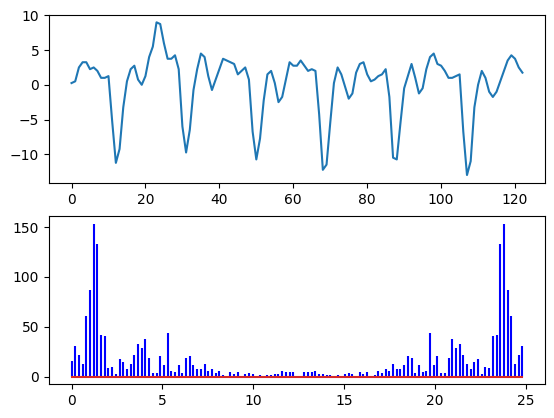

In [4]:
import numpy as np
from matplotlib import pyplot as plt


sample_data = np.array([0.25,0.5,2.5,3.25,3.25,2.25,2.5,2.0,1.0,1.0,1.25,-5.25,-11.25,-9.25,-3.25,0.5,2.25,2.75,0.75,0.0,1.25,4.0,5.5,9.0,8.75,6.0,3.75,3.75,4.25,2.25,-6.0,-9.75,-6.5,-0.75,2.25,4.5,4.0,1.25,-0.75,0.75,2.25,3.75,3.5,3.25,3.0,1.5,2.0,2.5,0.75,-6.75,-10.75,-7.75,-2.25,1.5,2.0,0.25,-2.5,-1.75,0.75,3.25,2.75,2.75,3.5,2.75,2.0,2.25,2.0,-4.25,-12.25,-11.5,-5.5,0.25,2.5,1.5,-0.25,-2.0,-1.25,1.75,3.0,3.25,1.5,0.5,0.75,1.25,1.5,2.25,-1.75,-10.5,-10.75,-5.5,-0.5,1.25,3.0,1.0,-1.25,-0.5,2.25,4.0,4.5,3.0,2.75,2.0,1.0,1.0,1.25,1.5,-6.75,-13.0,-11.0,-3.25,0.0,2.0,1.0,-1.0,-1.75,-1.0,0.5,2.0,3.5,4.25,3.75,2.5,1.75])
fft = np.real(np.fft.fft(sample_data))
time = np.arange(len(sample_data))

#frequency axis
sr = 25
N = len(fft)
T = N / sr
freq = time / T

nyquist = int(N/2)

freq_first_half = freq[:nyquist]
fft_first_half = fft[:nyquist] / nyquist

fig, axs = plt.subplots(2)

axs[0].plot(time,sample_data)
axs[1].stem(freq,np.abs(fft), 'b', \
    markerfmt=" ")


In [9]:
fundamental = freq[np.argmax(np.abs(fft)[0:10])]

print(fundamental*60)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (4027137592.py, line 1)